# Data Assignment 1 - `t54zheng` (20939203)


In [1]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Part 1 - Downloading and Reading Raw Data

WRDS Queries
- [8076602 - crsp](https://wrds-www.wharton.upenn.edu/query-manager/query/8076602/)
- [8076622 - compustat](https://wrds-www.wharton.upenn.edu/query-manager/query/8076622/)


In [2]:
# import raw data
crsp = pd.read_sas("crsp_nasdaq_100.sas7bdat", encoding = 'ISO-8859-1')
compustat = pd.read_sas("compustat_nasdaq_100.sas7bdat", encoding = 'ISO-8859-1')

### Data Cleanup

- Notice that there are more tickers in the crsp data than there are companies
- This means that some companies change ticker over the observed time period
- this means that we should actually include sort stocks by permno (as suggested in the assignment)

In [3]:
# Demonstrate this value is greater than 99 (size of our nasdaq 100 data)
print(f'CRSP Tickers - {len(set(crsp.TICKER))}')
print(f'Compustat Tickers - {len(set(compustat.TIC))}')

CRSP Tickers - 119
Compustat Tickers - 99


In [4]:
# To fix this, we will just add permnos to our compustat data
translation_df = pd.read_excel("nasdaq100_pop.xlsx", sheet_name="all", converters={"GVKEY":str, "PERMNO":str})
translation_dict = translation_df[["GVKEY", "PERMNO"]].set_index("GVKEY").to_dict()["PERMNO"]

In [5]:
compustat['PERMNO'] = compustat.apply(lambda row: translation_dict[row.GVKEY], axis=1)

## Part 2 - Merging the data

In [6]:
# Enumerate CRSP data using monthid
crsp['YEAR'] = pd.DatetimeIndex(crsp['DATE']).year
crsp['MONTH'] = pd.DatetimeIndex(crsp['DATE']).month
crsp['monthid_crsp'] = ((crsp['YEAR']) - 1996) * 12 + crsp['MONTH']
sqldf("SELECT * FROM crsp LIMIT 5")

,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,VWRETD,SPRTRN,YEAR,MONTH,monthid_crsp
0,10107.0,1997-01-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,102.0000,0.234493,0.234493,1198000.0,0.053473,0.061317,1997,1,13
1,10107.0,1997-02-28 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,97.5000,-0.044118,-0.044118,1198000.0,-0.001067,0.005928,1997,2,14
2,10107.0,1997-03-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,91.6875,-0.059615,-0.059615,1191000.0,-0.044889,-0.042614,1997,3,15
3,10107.0,1997-04-30 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,121.5000,0.325153,0.325153,1191000.0,0.042396,0.058406,1997,4,16
4,10107.0,1997-05-30 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,124.0000,0.020576,0.020576,1191000.0,0.071640,0.058577,1997,5,17


In [7]:
# Enumerate compustat data using monthid
compustat['YEAR'] = pd.DatetimeIndex(compustat['DATADATE']).year
compustat['MONTH'] = pd.DatetimeIndex(compustat['DATADATE']).month
compustat['monthid_compustat'] = ((compustat['YEAR']) - 1996) * 12 + compustat['MONTH']
sqldf("SELECT * FROM compustat LIMIT 5")

,GVKEY,DATADATE,FYEARQ,FQTR,CONM,TIC,DATACQTR,DATAFQTR,ATQ,CEQQ,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
0,001161,1996-03-31 00:00:00.000000,1996.0,1.0,ADVANCED MICRO DEVICES,AMD,1996Q1,1996Q1,2954.809,2121.948,...,C,INDL,STD,D,USD,A,61241,1996,3,3
1,001161,1996-06-30 00:00:00.000000,1996.0,2.0,ADVANCED MICRO DEVICES,AMD,1996Q2,1996Q2,2845.025,2071.355,...,C,INDL,STD,D,USD,A,61241,1996,6,6
2,001161,1996-09-30 00:00:00.000000,1996.0,3.0,ADVANCED MICRO DEVICES,AMD,1996Q3,1996Q3,3053.992,2036.658,...,C,INDL,STD,D,USD,A,61241,1996,9,9
3,001161,1996-12-31 00:00:00.000000,1996.0,4.0,ADVANCED MICRO DEVICES,AMD,1996Q4,1996Q4,3145.283,2021.878,...,C,INDL,STD,D,USD,A,61241,1996,12,12
4,001161,1997-03-31 00:00:00.000000,1997.0,1.0,ADVANCED MICRO DEVICES,AMD,1997Q1,1997Q1,3426.126,2043.757,...,C,INDL,STD,D,USD,A,61241,1997,3,15


In [8]:
df_compustat_crsp = sqldf("SELECT a.*, b.* \
                           FROM crsp as a \
                           LEFT JOIN compustat as b \
                           ON a.PERMNO = b.PERMNO and a.monthid_crsp >= b.monthid_compustat + 4 and a.monthid_crsp <= b.monthid_compustat + 6") # 3-month lag

***
# Cleaning our data
## Notice Duplicates
- Notice that our dataframe size exceeds our initial data size from CRSP of 23997 rows, so we have some duplicates
- And indeed we do (I found them using the command below, but showing them first so it's easier to understand)

In [9]:
df_compustat_crsp[6870:6881]

,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,VWRETD,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
6870,45911.0,2002-04-30 00:00:00.000000,83088M10,ALPHA INDUSTRIES INC,AHAA,12.25,-0.196721,-0.196721,44260.0,-0.049600,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6871,45911.0,2002-05-31 00:00:00.000000,83088M10,ALPHA INDUSTRIES INC,AHAA,10.19,-0.168163,-0.168163,44291.0,-0.010510,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6872,45911.0,2002-05-31 00:00:00.000000,83088M10,ALPHA INDUSTRIES INC,AHAA,10.19,-0.168163,-0.168163,44291.0,-0.010510,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6873,45911.0,2002-06-28 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,5.55,-0.455348,-0.455348,137368.0,-0.070259,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6874,45911.0,2002-06-28 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,5.55,-0.455348,-0.455348,137368.0,-0.070259,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6875,45911.0,2002-07-31 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,2.90,-0.477477,-0.477477,137510.0,-0.081125,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6876,45911.0,2002-07-31 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,2.90,-0.477477,-0.477477,137510.0,-0.081125,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6877,45911.0,2002-08-30 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,4.20,0.448276,0.448276,137510.0,0.007949,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6878,45911.0,2002-08-30 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,4.20,0.448276,0.448276,137510.0,0.007949,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6879,45911.0,2002-09-30 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,4.53,0.078572,0.078572,137589.0,-0.099923,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0


In [10]:
# These are our dropped rows
df_compustat_crsp[~df_compustat_crsp.index.isin(df_compustat_crsp.drop_duplicates(["PERMNO", "DATE"], ignore_index=False).index)]

,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,VWRETD,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
6870,45911.0,2002-04-30 00:00:00.000000,83088M10,ALPHA INDUSTRIES INC,AHAA,12.25,-0.196721,-0.196721,44260.0,-0.049600,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6872,45911.0,2002-05-31 00:00:00.000000,83088M10,ALPHA INDUSTRIES INC,AHAA,10.19,-0.168163,-0.168163,44291.0,-0.010510,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6874,45911.0,2002-06-28 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,5.55,-0.455348,-0.455348,137368.0,-0.070259,...,C,INDL,STD,D,USD,A,45911,2001.0,12.0,72.0
6876,45911.0,2002-07-31 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,2.90,-0.477477,-0.477477,137510.0,-0.081125,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6878,45911.0,2002-08-30 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,4.20,0.448276,0.448276,137510.0,0.007949,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0
6880,45911.0,2002-09-30 00:00:00.000000,83088M10,SKYWORKS SOLUTIONS INC,SWKS,4.53,0.078572,0.078572,137589.0,-0.099923,...,C,INDL,STD,D,USD,A,45911,2002.0,3.0,75.0


In [11]:
# So we drop the duplicates and we are good
df_compustat_crsp.drop_duplicates(["PERMNO", "DATE"], inplace=True)
df_compustat_crsp

,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,VWRETD,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
0,10107.0,1997-01-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,102.000000,0.234493,0.234493,1198000.0,0.053473,...,C,INDL,STD,D,USD,A,10107,1996.0,9.0,9.0
1,10107.0,1997-02-28 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,97.500000,-0.044118,-0.044118,1198000.0,-0.001067,...,C,INDL,STD,D,USD,A,10107,1996.0,9.0,9.0
2,10107.0,1997-03-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,91.687500,-0.059615,-0.059615,1191000.0,-0.044889,...,C,INDL,STD,D,USD,A,10107,1996.0,9.0,9.0
3,10107.0,1997-04-30 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,121.500000,0.325153,0.325153,1191000.0,0.042396,...,C,INDL,STD,D,USD,A,10107,1996.0,12.0,12.0
4,10107.0,1997-05-30 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,124.000000,0.020576,0.020576,1191000.0,0.071640,...,C,INDL,STD,D,USD,A,10107,1996.0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23998,93436.0,2022-08-31 00:00:00.000000,88160R10,TESLA INC,TSLA,275.609985,-0.072489,-0.072489,3133470.0,-0.036233,...,C,INDL,STD,D,USD,A,93436,2022.0,3.0,315.0
23999,93436.0,2022-09-30 00:00:00.000000,88160R10,TESLA INC,TSLA,265.250000,-0.037589,-0.037589,3158000.0,-0.091323,...,C,INDL,STD,D,USD,A,93436,2022.0,3.0,315.0
24000,93436.0,2022-10-31 00:00:00.000000,88160R10,TESLA INC,TSLA,227.539993,-0.142168,-0.142168,3157752.0,0.077394,...,C,INDL,STD,D,USD,A,93436,2022.0,6.0,318.0
24001,93436.0,2022-11-30 00:00:00.000000,88160R10,TESLA INC,TSLA,194.699997,-0.144326,-0.144326,3157752.0,0.052354,...,C,INDL,STD,D,USD,A,93436,2022.0,6.0,318.0


## Getting Ready for Questions 4-6
Finally, we keep the cleaned data from 2000-2022 for our next set of questions.

In [12]:
df_compustat_crsp_2000_2022 = df_compustat_crsp.loc[df_compustat_crsp["DATE"] >= "2000-01-01"]

In [13]:
df_compustat_crsp_2000_2022.reset_index(inplace=True)

In [14]:
# df_compustat_crsp_2000_2022.dropna(axis=0, inplace=True)

In [15]:
df_compustat_crsp_2000_2022

,index,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
0,36,10107.0,2000-01-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,97.875000,-0.161670,-0.161670,5160025.0,...,C,INDL,STD,D,USD,A,10107,1999.0,9.0,45.0
1,37,10107.0,2000-02-29 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,89.375000,-0.086845,-0.086845,5160025.0,...,C,INDL,STD,D,USD,A,10107,1999.0,9.0,45.0
2,38,10107.0,2000-03-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,106.250000,0.188811,0.188811,5242000.0,...,C,INDL,STD,D,USD,A,10107,1999.0,9.0,45.0
3,39,10107.0,2000-04-28 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,69.750000,-0.343529,-0.343529,5262405.0,...,C,INDL,STD,D,USD,A,10107,1999.0,12.0,48.0
4,40,10107.0,2000-05-31 00:00:00.000000,59491810,MICROSOFT CORP,MSFT,62.562500,-0.103047,-0.103047,5262405.0,...,C,INDL,STD,D,USD,A,10107,1999.0,12.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22015,23998,93436.0,2022-08-31 00:00:00.000000,88160R10,TESLA INC,TSLA,275.609985,-0.072489,-0.072489,3133470.0,...,C,INDL,STD,D,USD,A,93436,2022.0,3.0,315.0
22016,23999,93436.0,2022-09-30 00:00:00.000000,88160R10,TESLA INC,TSLA,265.250000,-0.037589,-0.037589,3158000.0,...,C,INDL,STD,D,USD,A,93436,2022.0,3.0,315.0
22017,24000,93436.0,2022-10-31 00:00:00.000000,88160R10,TESLA INC,TSLA,227.539993,-0.142168,-0.142168,3157752.0,...,C,INDL,STD,D,USD,A,93436,2022.0,6.0,318.0
22018,24001,93436.0,2022-11-30 00:00:00.000000,88160R10,TESLA INC,TSLA,194.699997,-0.144326,-0.144326,3157752.0,...,C,INDL,STD,D,USD,A,93436,2022.0,6.0,318.0


***
## Task 4 - Creating our additional Variables
We'll add the three additional variables `lnSize`, `bk2mkt`, `eP`

There were some negative numbers in our data that was causing errors, so we will correct them (share price shouldn't be negative anyway)

We also can support our hypothesis by looking at this data, the price stays in $4 range, so the -4 price seems like an input error

In [17]:
test = df_compustat_crsp_2000_2022[df_compustat_crsp_2000_2022["CUSIP"] == '61174X10']
test[test["DATE"] >= '2001-31-01'].head(3)

,index,PERMNO,DATE,CUSIP,COMNAM,TICKER,PRC,RET,RETX,SHROUT,...,CONSOL,INDFMT,DATAFMT,POPSRC,CURCDQ,COSTAT,PERMNO,YEAR,MONTH,monthid_compustat
17284,19231,88031.0,2002-01-31 00:00:00.000000,61174X10,HANSEN NATURAL CORP,HANS,-4.21,0.002381,0.002381,10045.0,...,C,INDL,STD,D,USD,A,88031,2001.0,9.0,69.0
17285,19232,88031.0,2002-02-28 00:00:00.000000,61174X10,HANSEN NATURAL CORP,HANS,4.14,-0.016627,-0.016627,10045.0,...,C,INDL,STD,D,USD,A,88031,2001.0,9.0,69.0
17286,19233,88031.0,2002-03-28 00:00:00.000000,61174X10,HANSEN NATURAL CORP,HANS,4.22,0.019324,0.019324,10053.0,...,C,INDL,STD,D,USD,A,88031,2001.0,9.0,69.0


In [18]:
# Fix data
# df_compustat_crsp_2000_2022["PRC"]
df_compustat_crsp_2000_2022.loc[:,"PRC"] = df_compustat_crsp_2000_2022["PRC"].abs()

# For CRSP, shares outstanding is in thousands
df_compustat_crsp_2000_2022.loc[:,"SHROUT"] *= 1_000

# We need to convert our compustat units to match that of CRSP
# Also note that IBQ, ATQ, CEQQ is reported in millions
df_compustat_crsp_2000_2022.loc[:,"ATQ"] *= 1_000_000
df_compustat_crsp_2000_2022.loc[:,"CEQQ"] *= 1_000_000
df_compustat_crsp_2000_2022.loc[:,"IBQ"] *= 1_000_000
df_compustat_crsp_2000_2022.loc[:,"SALEQ"] *= 1_000_000

In [19]:
# a. lnSize
df_compustat_crsp_2000_2022.loc[:,"mktcap"] = df_compustat_crsp_2000_2022["PRC"] * df_compustat_crsp_2000_2022["SHROUT"]
df_compustat_crsp_2000_2022.loc[:,"lnSize"] = np.log(df_compustat_crsp_2000_2022["mktcap"])

# b. bk2mkt - assuming [CEQQ] Common/Ordinary Equity – Total means Book Value of Equity
df_compustat_crsp_2000_2022.loc[:,"bk2mkt"] = df_compustat_crsp_2000_2022["mktcap"] / df_compustat_crsp_2000_2022["ATQ"]

# c. eP
df_compustat_crsp_2000_2022.loc[:,"eP1"] = df_compustat_crsp_2000_2022["IBQ"] / df_compustat_crsp_2000_2022["mktcap"]
df_compustat_crsp_2000_2022.loc[:,"eP2"] = df_compustat_crsp_2000_2022["EPSPXQ"] / df_compustat_crsp_2000_2022["PRC"]

In [20]:
df_compustat_crsp_2000_2022[["ATQ", "mktcap", "bk2mkt"]].mean()

ATQ       2.426044e+10
mktcap    5.575885e+10
bk2mkt    3.750454e+00
dtype: float64

In [21]:
# Now let's compare the standard deviation of the two methods of computing the earnings-to-price ratio

# eP1 is IBQ (Income) / Market Equity
print(f"eP1 - IBQ / Market Equity - mean: {df_compustat_crsp_2000_2022.eP1.mean():.4f} | stdev: {df_compustat_crsp_2000_2022.eP1.std():.4f}")

# eP2 is EPSPXQ (Earnings per share) / PRC (Share Price)
print(f"eP2 - EPSPXQ (Earnings per share) / Prc - mean: {df_compustat_crsp_2000_2022.eP2.mean():.4f} | stdev: {df_compustat_crsp_2000_2022.eP2.std():.4f}")

eP1 - IBQ / Market Equity - mean: 0.0037 | stdev: 0.1142
eP2 - EPSPXQ (Earnings per share) / Prc - mean: 0.0024 | stdev: 0.1539


In [22]:
df_compustat_crsp_2000_2022.eP1.describe()

count    21781.000000
mean         0.003660
std          0.114157
min        -11.134857
25%          0.003298
50%          0.008581
75%          0.013624
max          0.244064
Name: eP1, dtype: float64

In [23]:
df_compustat_crsp_2000_2022.eP2.describe()

count    21775.000000
mean         0.002445
std          0.153872
min        -16.083334
25%          0.003290
50%          0.008475
75%          0.013188
max          0.276550
Name: eP2, dtype: float64

## eP1 vs eP2

The two measures both illustrate how the market values the company's quarterly earnings. The difference is that `eP1`, which is calulated as total income / total market equity, represents the ratio at which the entire company is valued compared to its earnings. On the other hand, `eP2` represents how the company's earnings is valued at a per-share basis.

Statistically, we may say that the latter (eP2) is the better comaprison because it has a smaller standard deviation 

## Analysis
- We will plot the distribution of each statistic, in an **aggregate** histogram including all stocks being analyzed.

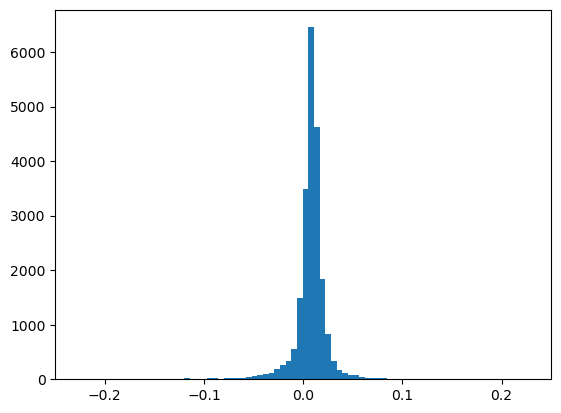

In [24]:
plt.hist(df_compustat_crsp_2000_2022["eP1"], bins=2000)
# Remove outlier
plt.xlim(-0.25, 0.25)
plt.show()

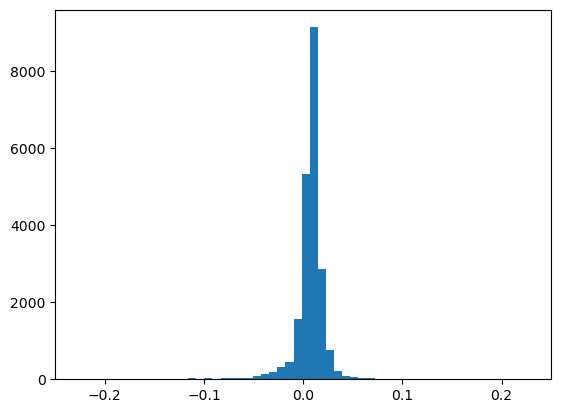

In [25]:
plt.hist(df_compustat_crsp_2000_2022["eP2"], bins=2000)
# Remove outlier
plt.xlim(-0.25, 0.25)
plt.show()

## Question 5
- We wish to calculate some descriptive statistics for the variables we made above
- We again assume we are doing so by aggregating all of the stocks together.

In [26]:
statistics_df = pd.DataFrame(columns=["", "lnSize", "bk2mkt", "eP1", "eP2"])
statistics_df.loc[0] = "mean"
statistics_df.loc[1] = "median"
statistics_df.loc[2] = "variance"
statistics_df.loc[3] = "standard deviation"
statistics_df.loc[4] = "5th Percentile"
statistics_df.loc[5] = "25th Percentile"
statistics_df.loc[6] = "50th Percentile"
statistics_df.loc[7] = "75th Percentile"
statistics_df.loc[8] = "95th Percentile"

statistics_df.set_index("", inplace=True)

variables = ["lnSize", "bk2mkt", "eP1", "eP2"]


# Mean + Median
for var in variables:
    statistics_df.loc["mean", var] = df_compustat_crsp_2000_2022[var].mean()
    statistics_df.loc["median", var] = df_compustat_crsp_2000_2022[var].median()

# Variance + Std Deviation
for var in variables:
    statistics_df.loc["variance", var] = df_compustat_crsp_2000_2022[var].var()
    statistics_df.loc["standard deviation", var] = df_compustat_crsp_2000_2022[var].std()

# Percentiles
percentiles = [5, 25, 50, 75, 95]
for var in variables:
    for p in percentiles:
        statistics_df.loc[f"{p}th Percentile", var] = df_compustat_crsp_2000_2022[var].quantile(p / 100)

statistics_df.astype(float).round(4)

,lnSize,bk2mkt,eP1,eP2
,,,,
mean,23.5527,3.7505,0.0037,0.0024
median,23.6426,2.5864,0.0086,0.0085
variance,2.5257,17.5253,0.0130,0.0237
standard deviation,1.5892,4.1863,0.1142,0.1539
5th Percentile,20.8414,0.4667,-0.0192,-0.0194
25th Percentile,22.5964,1.4123,0.0033,0.0033
50th Percentile,23.6426,2.5864,0.0086,0.0085
75th Percentile,24.5537,4.6855,0.0136,0.0132
95th Percentile,25.9621,10.7952,0.0267,0.0242


## Data Clean-Up

We will choose to **winsorize** our data, since the validity of our data should be good. I.e. the data that we have downloaded is not incorrect, but just reflects the notion that surprise stock events are a reality and should be reflected in the data. So, instead of truncating them to be removed, we just winsorize them so that they are included in the data, but we do not influence the skew of the data too much.

### Group by month
Since we compare cross-sectionally across all stocks in a given month, we need to group by monthid to winsorize.

In [27]:
df_compustat_crsp_2000_2022[["monthid_crsp", "monthid_compustat"]]

,monthid_crsp,monthid_compustat
0,49,45.0
1,50,45.0
2,51,45.0
3,52,48.0
4,53,48.0
...,...,...
22015,320,315.0
22016,321,315.0
22017,322,318.0
22018,323,318.0


In [28]:
# Let's use the crsp monthly data to winsortize.
# We'll create a new dataframe that includes the 

winsorize_limits_df = pd.DataFrame(columns = ["monthid", "lnSize std", "bk2mkt std", "eP1 std", "eP2 std"])
winsorize_limits_df.loc[:,"monthid"] = list(set(df_compustat_crsp_2000_2022["monthid_crsp"]))
winsorize_limits_df.set_index("monthid", inplace=True)

winsorize_limits_df

,lnSize std,bk2mkt std,eP1 std,eP2 std
monthid,,,,
49,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN
...,...,...,...,...
320,NaN,NaN,NaN,NaN
321,NaN,NaN,NaN,NaN
322,NaN,NaN,NaN,NaN


In [29]:
for monthid in winsorize_limits_df.index:
    cross_section_df = df_compustat_crsp_2000_2022[df_compustat_crsp_2000_2022["monthid_crsp"] == monthid]
    winsorize_limits_df.loc[monthid, "lnSize std"] = cross_section_df["lnSize"].std()
    winsorize_limits_df.loc[monthid, "bk2mkt std"] = cross_section_df["bk2mkt"].std()
    winsorize_limits_df.loc[monthid, "eP1 std"] = cross_section_df["eP1"].std()
    winsorize_limits_df.loc[monthid, "eP2 std"] = cross_section_df["eP2"].std()
winsorize_limits_df

,lnSize std,bk2mkt std,eP1 std,eP2 std
monthid,,,,
49,1.860556,10.669781,0.016697,0.017858
50,1.815236,15.087059,0.017461,0.014015
51,1.856632,12.200536,0.01595,0.013016
52,1.868604,8.290153,0.016809,0.017197
53,1.82503,7.294563,0.022943,0.024512
...,...,...,...,...
320,1.06967,2.95932,0.029081,0.035761
321,1.08189,2.732847,0.040488,0.046024
322,1.090649,2.802746,0.051561,0.053423


In [30]:
# Winsorize
df_compustat_crsp_2000_2022.loc[:,"lnSize (winsorized)"] = df_compustat_crsp_2000_2022.lnSize
df_compustat_crsp_2000_2022.loc[:,"bk2mkt (winsorized)"] = df_compustat_crsp_2000_2022.bk2mkt

df_compustat_crsp_2000_2022.loc[:,"eP1 (winsorized)"] = df_compustat_crsp_2000_2022.eP1
df_compustat_crsp_2000_2022.loc[:,"eP2 (winsorized)"] = df_compustat_crsp_2000_2022.eP2

columns = ["lnSize (winsorized)", "bk2mkt (winsorized)", "eP1 (winsorized)", "eP2 (winsorized)"]

def winsorize(month_section):
    for col in columns:
        mean = month_section[col].mean()
        std = month_section[col].std()

        upper = mean + 3 * std
        lower = mean - 3 * std

        month_section[col] = np.clip(month_section[col], lower, upper)
    return month_section


# Winsorize
df_compustat_crsp_2000_2022 = df_compustat_crsp_2000_2022.groupby(df_compustat_crsp_2000_2022["monthid_crsp"]).apply(winsorize)

In [31]:
# Reset the index
df_compustat_crsp_2000_2022.set_index("index", inplace=True)

In [32]:
# Now we will redo the statistics df

winsorized_statistics_df = pd.DataFrame(columns=["", "lnSize (winsorized)", "bk2mkt (winsorized)", "eP1 (winsorized)", "eP2 (winsorized)"])
winsorized_statistics_df.loc[0] = "mean"
winsorized_statistics_df.loc[1] = "median"
winsorized_statistics_df.loc[2] = "variance"
winsorized_statistics_df.loc[3] = "standard deviation"
winsorized_statistics_df.loc[4] = "5th Percentile"
winsorized_statistics_df.loc[5] = "25th Percentile"
winsorized_statistics_df.loc[6] = "50th Percentile"
winsorized_statistics_df.loc[7] = "75th Percentile"
winsorized_statistics_df.loc[8] = "95th Percentile"

winsorized_statistics_df.set_index("", inplace=True)

variables = ["lnSize (winsorized)", "bk2mkt (winsorized)", "eP1 (winsorized)", "eP2 (winsorized)"]


# Mean + Median
for var in variables:
    winsorized_statistics_df.loc["mean", var] = df_compustat_crsp_2000_2022[var].mean()
    winsorized_statistics_df.loc["median", var] = df_compustat_crsp_2000_2022[var].median()

# Variance + Std Deviation
for var in variables:
    winsorized_statistics_df.loc["variance", var] = df_compustat_crsp_2000_2022[var].var()
    winsorized_statistics_df.loc["standard deviation", var] = df_compustat_crsp_2000_2022[var].std()

# Percentiles
percentiles = [5, 25, 50, 75, 95]
for var in variables:
    for p in percentiles:
        winsorized_statistics_df.loc[f"{p}th Percentile", var] = df_compustat_crsp_2000_2022[var].quantile(p / 100)

winsorized_statistics_df.astype(float).round(4)

,lnSize (winsorized),bk2mkt (winsorized),eP1 (winsorized),eP2 (winsorized)
,,,,
mean,23.5520,3.6576,0.0057,0.0048
median,23.6426,2.5864,0.0086,0.0085
variance,2.5042,12.5595,0.0023,0.0039
standard deviation,1.5825,3.5439,0.0484,0.0621
5th Percentile,20.8421,0.4667,-0.0192,-0.0191
25th Percentile,22.5964,1.4123,0.0033,0.0033
50th Percentile,23.6426,2.5864,0.0086,0.0085
75th Percentile,24.5537,4.6855,0.0136,0.0132
95th Percentile,25.9621,10.6826,0.0267,0.0242


In [33]:
statistics_df.astype(float).round(4)

,lnSize,bk2mkt,eP1,eP2
,,,,
mean,23.5527,3.7505,0.0037,0.0024
median,23.6426,2.5864,0.0086,0.0085
variance,2.5257,17.5253,0.0130,0.0237
standard deviation,1.5892,4.1863,0.1142,0.1539
5th Percentile,20.8414,0.4667,-0.0192,-0.0194
25th Percentile,22.5964,1.4123,0.0033,0.0033
50th Percentile,23.6426,2.5864,0.0086,0.0085
75th Percentile,24.5537,4.6855,0.0136,0.0132
95th Percentile,25.9621,10.7952,0.0267,0.0242


***
## Testing Asset Pricing Model Validity

TODO

**ALSO MAKE SURE TO GO BACK TO Q4 FOR PLOTTING**

- Use lambda significance test to determine significance at each month for each stock

In [34]:
# Import data
ff3 = pd.read_sas("ff_3+mom.sas7bdat", encoding = 'ISO-8859-1')
ff5x5 = pd.read_sas("ff_5x5-value-weighted.sas7bdat", encoding = 'ISO-8859-1')

In [35]:
ff3

,DATEFF,SMB,HML,MKTRF,RF,UMD
0,1980-01-31,0.0162,0.0175,0.0551,0.0080,0.0755
1,1980-02-29,-0.0185,0.0061,-0.0122,0.0089,0.0788
2,1980-03-31,-0.0664,-0.0101,-0.1290,0.0121,-0.0955
3,1980-04-30,0.0105,0.0106,0.0397,0.0126,-0.0043
4,1980-05-30,0.0213,0.0038,0.0526,0.0081,-0.0112
...,...,...,...,...,...,...
523,2023-08-31,-0.0316,-0.0106,-0.0239,0.0045,0.0377
524,2023-09-29,-0.0251,0.0152,-0.0524,0.0043,0.0026
525,2023-10-31,-0.0387,0.0019,-0.0319,0.0047,0.0173
526,2023-11-30,-0.0002,0.0164,0.0884,0.0044,0.0275


In [36]:
ff5x5[["DATE", "S1B1_VWRET"]]

,DATE,S1B1_VWRET
0,1980-01-31,0.128968
1,1980-02-29,0.005566
2,1980-03-31,-0.220383
3,1980-04-30,0.062197
4,1980-05-30,0.072297
...,...,...
523,2023-08-31,-0.122376
524,2023-09-29,-0.082275
525,2023-10-31,-0.102240
526,2023-11-30,0.057861


## Tackling the problem
- Our ff3 and ff5x5 dataframes are aligned (datewise) well, so we can go straight into our analysis
- We will be using the two-stage regression to estimate each factor loading.
- I.e. we will find the betas for CAPM and for and the FF 3-factor model for each of our 25 value-weighted portfolios.
- We can then plot each portfolio to compare CAPM vs Fama-French 3-factor

**To make sure we don't have look-ahead bias. We will train/backtest our data on 1980-2000 data and test on 2000-2023**

In [37]:
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as stats

portfolios = list(ff5x5.columns[1:])
portfolios

['S1B1_VWRET',
 'S1B2_VWRET',
 'S1B3_VWRET',
 'S1B4_VWRET',
 'S1B5_VWRET',
 'S2B1_VWRET',
 'S2B2_VWRET',
 'S2B3_VWRET',
 'S2B4_VWRET',
 'S2B5_VWRET',
 'S3B1_VWRET',
 'S3B2_VWRET',
 'S3B3_VWRET',
 'S3B4_VWRET',
 'S3B5_VWRET',
 'S4B1_VWRET',
 'S4B2_VWRET',
 'S4B3_VWRET',
 'S4B4_VWRET',
 'S4B5_VWRET',
 'S5B1_VWRET',
 'S5B2_VWRET',
 'S5B3_VWRET',
 'S5B4_VWRET',
 'S5B5_VWRET']

In [38]:
beta = {'portfolio':[], 'date':[], 'beta': [], 'capm_alpha': [], 'ff3_beta':[], 'smb_beta':[], 'hml_beta':[], 'ff3_alpha': []}
ff_factors = {'portfolio':[], 'date':[], 'SMB': [], 'HML': [], 'MKTRF': [], 'RF': []} # Holds expected values of the factors
for portfolio in portfolios:
    portfolio_returns = ff5x5[["DATE", portfolio]]

    # (strict) 36-month lookback
    for i in range(36, len(ff3)):
        date = portfolio_returns.iloc[i, 0] # Data should predict the return at this date
                                            # Note that this date is not actually used in the below regression
        returns = portfolio_returns.iloc[i-36:i, 1]
        factors = ff3.iloc[i-36:i]
        current_factor = ff3.iloc[i]

        CAPMmodel = linear_model.LinearRegression().fit(factors[["MKTRF"]], returns)
        ff3model = linear_model.LinearRegression(n_jobs=3).fit(factors[["MKTRF", "SMB", "HML"]], returns)

        beta['portfolio'].append(portfolio)
        beta['date'].append(date)
        beta['beta'].append(CAPMmodel.coef_[0])
        beta['capm_alpha'].append(CAPMmodel.intercept_)
        beta['ff3_beta'].append(ff3model.coef_[0])
        beta['smb_beta'].append(ff3model.coef_[1])
        beta['hml_beta'].append(ff3model.coef_[2])
        beta['ff3_alpha'].append(ff3model.intercept_)

        ff_factors['portfolio'].append(portfolio)
        ff_factors['date'].append(date)
        
        # Even better - use  at time t - TODO is this right?
        ff_factors['SMB'].append(current_factor["SMB"])
        ff_factors['HML'].append(current_factor["HML"])
        ff_factors['MKTRF'].append(current_factor["MKTRF"])
        ff_factors['RF'].append(current_factor["RF"])
        # # Better - Use the last record as the prediction for the next return
        # ff_factors['SMB'].append(list(factors["SMB"])[-1])
        # ff_factors['HML'].append(list(factors["HML"])[-1])
        # ff_factors['MKTRF'].append(list(factors["MKTRF"])[-1])
        # ff_factors['RF'].append(list(factors["RF"])[-1])
        
        # Add expected values of each of the factors, which are the average across the 36 months (our best prediction)
        # ff_factors['SMB'].append(factors["SMB"].mean())
        # ff_factors['HML'].append(factors["HML"].mean())
        # ff_factors['MKTRF'].append(factors["MKTRF"].mean())
        # ff_factors['RF'].append(factors["RF"].mean())

In [39]:
beta_df = pd.DataFrame.from_dict(beta)

In [40]:
beta_df

,portfolio,date,beta,capm_alpha,ff3_beta,smb_beta,hml_beta,ff3_alpha
0,S1B1_VWRET,1983-01-31,1.480847,0.007798,1.093489,1.095613,-0.550795,0.005225
1,S1B1_VWRET,1983-02-28,1.484370,0.008724,1.044246,1.138280,-0.628500,0.005385
2,S1B1_VWRET,1983-03-31,1.483650,0.007892,1.037300,1.146077,-0.640817,0.003423
3,S1B1_VWRET,1983-04-29,1.413253,0.008915,0.941840,1.039245,-0.766575,0.005995
4,S1B1_VWRET,1983-05-31,1.392782,0.008344,0.930223,1.036124,-0.781672,0.005811
...,...,...,...,...,...,...,...,...
12295,S5B5_VWRET,2023-08-31,0.951214,0.010182,1.060325,0.298932,0.900891,0.000394
12296,S5B5_VWRET,2023-09-29,1.005848,0.009404,1.081720,0.318406,0.903631,-0.000112
12297,S5B5_VWRET,2023-10-31,0.977924,0.011125,1.067452,0.303075,0.902855,0.000722
12298,S5B5_VWRET,2023-11-30,0.991374,0.009936,1.056641,0.333589,0.911523,0.001412


In [41]:
# TODO How to do t-test?

In [42]:
beta_df["real_ret"] = None
ff5x5.set_index("DATE", inplace=True)

In [43]:
# Now we calculate the expected CAPM and FF3 Returns for each date
# And we also add the actual return
for i in range(len(beta_df)):
    date = beta_df.iloc[i].loc["date"]
    portfolio = beta_df.iloc[i].loc["portfolio"]
    beta_df.iloc[i, -1] = ff5x5.loc[date][portfolio]

In [44]:
beta_df

,portfolio,date,beta,capm_alpha,ff3_beta,smb_beta,hml_beta,ff3_alpha,real_ret
0,S1B1_VWRET,1983-01-31,1.480847,0.007798,1.093489,1.095613,-0.550795,0.005225,0.134493
1,S1B1_VWRET,1983-02-28,1.484370,0.008724,1.044246,1.138280,-0.628500,0.005385,0.032025
2,S1B1_VWRET,1983-03-31,1.483650,0.007892,1.037300,1.146077,-0.640817,0.003423,0.026822
3,S1B1_VWRET,1983-04-29,1.413253,0.008915,0.941840,1.039245,-0.766575,0.005995,0.072592
4,S1B1_VWRET,1983-05-31,1.392782,0.008344,0.930223,1.036124,-0.781672,0.005811,0.123799
...,...,...,...,...,...,...,...,...,...
12295,S5B5_VWRET,2023-08-31,0.951214,0.010182,1.060325,0.298932,0.900891,0.000394,-0.073853
12296,S5B5_VWRET,2023-09-29,1.005848,0.009404,1.081720,0.318406,0.903631,-0.000112,-0.02237
12297,S5B5_VWRET,2023-10-31,0.977924,0.011125,1.067452,0.303075,0.902855,0.000722,-0.040377
12298,S5B5_VWRET,2023-11-30,0.991374,0.009936,1.056641,0.333589,0.911523,0.001412,0.15251


In [45]:
ff_factors_df = pd.DataFrame.from_dict(ff_factors)

In [46]:
ff_factors_df

,portfolio,date,SMB,HML,MKTRF,RF
0,S1B1_VWRET,1983-01-31,0.0273,-0.0075,0.0360,0.0069
1,S1B1_VWRET,1983-02-28,0.0327,0.0070,0.0259,0.0062
2,S1B1_VWRET,1983-03-31,0.0173,0.0202,0.0282,0.0063
3,S1B1_VWRET,1983-04-29,0.0050,0.0049,0.0667,0.0071
4,S1B1_VWRET,1983-05-31,0.0624,-0.0140,0.0052,0.0069
...,...,...,...,...,...,...
12295,S5B5_VWRET,2023-08-31,-0.0316,-0.0106,-0.0239,0.0045
12296,S5B5_VWRET,2023-09-29,-0.0251,0.0152,-0.0524,0.0043
12297,S5B5_VWRET,2023-10-31,-0.0387,0.0019,-0.0319,0.0047
12298,S5B5_VWRET,2023-11-30,-0.0002,0.0164,0.0884,0.0044


In [47]:
# TODO Calulcate expected return from each model
beta_df["capm_exp_ret"] = beta_df["beta"] * ff_factors_df["MKTRF"] + ff_factors_df["RF"] + beta_df["capm_alpha"]
beta_df["ff3_exp_ret"] = beta_df["ff3_beta"] * ff_factors_df["MKTRF"] + \
                             beta_df["smb_beta"] * ff_factors_df["SMB"] + \
                                beta_df["hml_beta"] * ff_factors_df["HML"] + ff_factors_df["RF"] + beta_df["ff3_alpha"]

In [48]:
beta_df

,portfolio,date,beta,capm_alpha,ff3_beta,smb_beta,hml_beta,ff3_alpha,real_ret,capm_exp_ret,ff3_exp_ret
0,S1B1_VWRET,1983-01-31,1.480847,0.007798,1.093489,1.095613,-0.550795,0.005225,0.134493,0.068008,0.085532
1,S1B1_VWRET,1983-02-28,1.484370,0.008724,1.044246,1.138280,-0.628500,0.005385,0.032025,0.053370,0.071454
2,S1B1_VWRET,1983-03-31,1.483650,0.007892,1.037300,1.146077,-0.640817,0.003423,0.026822,0.056031,0.045857
3,S1B1_VWRET,1983-04-29,1.413253,0.008915,0.941840,1.039245,-0.766575,0.005995,0.072592,0.110279,0.077355
4,S1B1_VWRET,1983-05-31,1.392782,0.008344,0.930223,1.036124,-0.781672,0.005811,0.123799,0.022487,0.093146
...,...,...,...,...,...,...,...,...,...,...,...
12295,S5B5_VWRET,2023-08-31,0.951214,0.010182,1.060325,0.298932,0.900891,0.000394,-0.073853,-0.008052,-0.039444
12296,S5B5_VWRET,2023-09-29,1.005848,0.009404,1.081720,0.318406,0.903631,-0.000112,-0.02237,-0.039002,-0.046751
12297,S5B5_VWRET,2023-10-31,0.977924,0.011125,1.067452,0.303075,0.902855,0.000722,-0.040377,-0.015370,-0.038643
12298,S5B5_VWRET,2023-11-30,0.991374,0.009936,1.056641,0.333589,0.911523,0.001412,0.15251,0.101973,0.114102


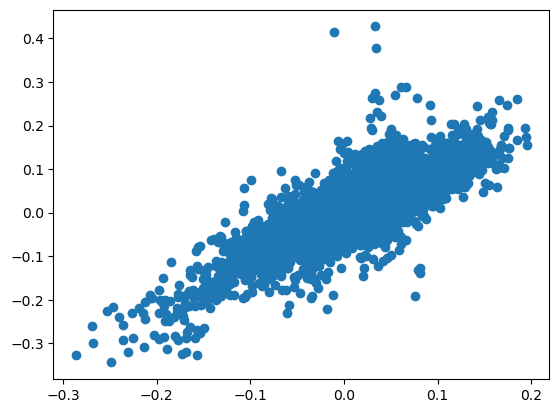

In [49]:
plt.scatter(x = beta_df["capm_exp_ret"], y = beta_df["real_ret"])

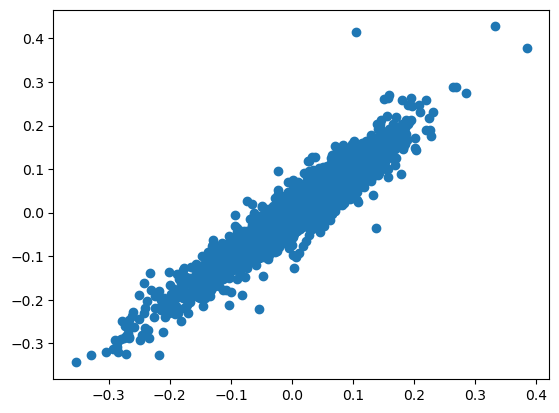

In [50]:
plt.scatter(x = beta_df["ff3_exp_ret"], y = beta_df["real_ret"])

In [51]:
stats.linregress(list(beta_df["capm_exp_ret"]), list(beta_df["real_ret"]))

LinregressResult(slope=0.9779260604153203, intercept=-0.0032879838144445755, rvalue=0.8331949963545852, pvalue=0.0, stderr=0.005852628943212582, intercept_stderr=0.0002980265788302604)

In [52]:
stats.linregress(list(beta_df["ff3_exp_ret"]), list(beta_df["real_ret"]))

LinregressResult(slope=0.9851077700150591, intercept=-0.003312769132297841, rvalue=0.9503077253974012, pvalue=0.0, stderr=0.0029100352462257477, intercept_stderr=0.0001662387674632631)

In [53]:
# Now we run our t-tests to see how significant everything is
explanatory_df = pd.DataFrame()
explanatory_df['ex_ret'] = beta_df['real_ret'] - ff_factors_df["RF"]
explanatory_df['date'] = beta_df['date']
explanatory_df

,ex_ret,date
0,0.127593,1983-01-31
1,0.025825,1983-02-28
2,0.020522,1983-03-31
3,0.065492,1983-04-29
4,0.116899,1983-05-31
...,...,...
12295,-0.078353,2023-08-31
12296,-0.02667,2023-09-29
12297,-0.045077,2023-10-31
12298,0.14811,2023-11-30


In [54]:
lambdas = {'date': [], 'beta': [],'ff3_beta': [],'smb_beta': [],'hml_beta': []}
for date in set(beta_df['date']):
    date_group = beta_df.loc[beta_df['date'] == date]
    # print(explanatory_df.loc[explanatory_df['date'] == date])
    
    CAPMmodel = linear_model.LinearRegression().fit(date_group[["beta"]], explanatory_df.loc[explanatory_df['date'] == date]["ex_ret"])
    FF3Model = linear_model.LinearRegression(n_jobs=3).fit(date_group[["ff3_beta", "smb_beta", "hml_beta"]], explanatory_df.loc[explanatory_df['date'] == date]["ex_ret"])
    
    lambdas['date'].append(date)
    lambdas['beta'].append(CAPMmodel.coef_[0])
    lambdas['ff3_beta'].append(FF3Model.coef_[0])
    lambdas['smb_beta'].append(FF3Model.coef_[1])
    lambdas['hml_beta'].append(FF3Model.coef_[2])

In [55]:
lambda_stats = ["beta", "ff3_beta", "smb_beta", "hml_beta"]
results_dict = {}
for statistic in lambda_stats:
    values = lambdas[statistic]
    ttest = stats.ttest_ind(values, np.zeros(len(values)))
    results_dict[f'{statistic}_t_stat'] =  ttest[0]
    results_dict[f'{statistic}_p_value'] =  ttest[1]

In [59]:
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df

,0
beta_t_stat,-1.146449
beta_p_value,0.251889
ff3_beta_t_stat,-1.744842
ff3_beta_p_value,0.081325
smb_beta_t_stat,-0.008800
smb_beta_p_value,0.992981
hml_beta_t_stat,1.309457
hml_beta_p_value,0.190686


## Factor Pricing
- We see that for CAPM, we have a t-stat if 1.146, which is not enough to reject our null hypothesis of beta being significant in modelling returns
- However, for our FF values it is a different story.
- Our FF3 beta has a higher t-stat if 1.75, which is enough for a 90% confidence interval

Other statistics have weak levels of significance

In [ ]:
# TODO try grouping by company